## Importing the necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

## Reading the data

In [2]:
# Reading the data from the excel sheet and storing it in a pandas DataFrame

data = pd.read_excel("ecommerce.xlsx")

In [3]:
data.head()

# Viewing the first 5 rows

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


In [4]:
data.shape

# Looking at the number of rows and columns

(20000, 15)

## Cleaning and preparing the data 

To visualise the number of missing values in each column, a heatmap is drawn using the seaborn library. The pandas.DataFrame.isnull() method returns an DataFrame of booleans (True if the data in a particular cell is missing and False otherwise). This dataframe is passed as an argument to the seaborn.heatmap() method and a heatmap is generated

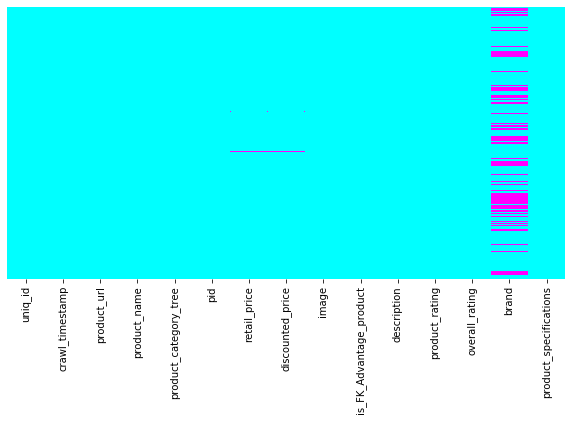

In [5]:
# Visualizing missing values in each column
# To visualise the number of missing values in each column, a heatmap is drawn using the seaborn library.

plt.figure(figsize = (10,5))

sns.heatmap(data.isnull(), cmap = "cool", yticklabels = False, cbar = False )

plt.show()



 From the above heatmap, we see that the 'brand' feature has a large number of values missing. Rest of the columns are fine

In [22]:
# Checking for duplicate data

data.duplicated().value_counts()

False    20000
dtype: int64

None of the columns have duplicate values

The following code separates the primary category. The list 'category' stores the primary categories of all the items. 
At first, 'category' is declared as an empty list. A for loop iterates over the values in 'product_category_tree' column.
The variable 'primary_category' stores the primary category from the product_category_tree column for each row. 
The inner for loop iterates over the entry of product_category_tree for that particular row. 
To eliminate non-alphabets, .isalpha() method is used as the condition of the first if statement. The break statement
is used to transfer the control of the program out of the inner for loop when the ">" character is encountered. 
This is because, in the entries of the product_category_tree column, the primary and secondary categories are separated by ">". The words before ">" will be considered as the primary category and will be appended to the list 'category'. 
Finally, the category list is assigned to the product_category_tree column.

In [7]:
category = []
for element in data.product_category_tree:
    primary_category = ""
    for character in element:
        if (character.isalpha()):
            primary_category += character
        if (character == ">"):
            break
    category.append(primary_category)

# print(category)  

data.product_category_tree = category



Some categories are very similar and they mean exactly the same thing. For example, 'HomeFurnishing' and 'Furniture' mean the same thing. Hence, they should belong to the same category. The following code assigns the category 'Furniture' to
'HomeFurnishing', 'KitchenDining' to 'HomeKitchen', 'BeautyandPersonalCare' to 'HealthPersonalCareAppliances', 'Eyewear' to  'Sunglasses'.

In [8]:


for i in range(len(data.product_category_tree)):
    if (data.product_category_tree[i] == "HomeFurnishing"):
        data.product_category_tree[i] = "Furniture"
    elif (data.product_category_tree[i] == "HomeKitchen"):
        data.product_category_tree[i] = "KitchenDining"
    elif (data.product_category_tree[i] == "HealthPersonalCareAppliances"):
        data.product_category_tree[i] = "BeautyandPersonalCare"
    elif (data.product_category_tree[i] == "Sunglasses"):
        data.product_category_tree[i] = "Eyewear"
        

C:\Users\Sinjini\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Sinjini\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Sinjini\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [9]:
data.product_category_tree.value_counts()[:20]

# This gives us the number of sales in the top 20 categories

Clothing                 6198
Jewellery                3531
Footwear                 1227
MobilesAccessories       1099
Automotive               1012
HomeDecorFestiveNeeds     929
Furniture                 880
BeautyandPersonalCare     753
KitchenDining             671
Computers                 578
Watches                   530
BabyCare                  483
ToolsHardware             391
ToysSchoolSupplies        330
PensStationery            313
BagsWalletsBelts          265
SportsFitness             166
CamerasAccessories         82
HomeImprovement            81
Eyewear                    50
Name: product_category_tree, dtype: int64

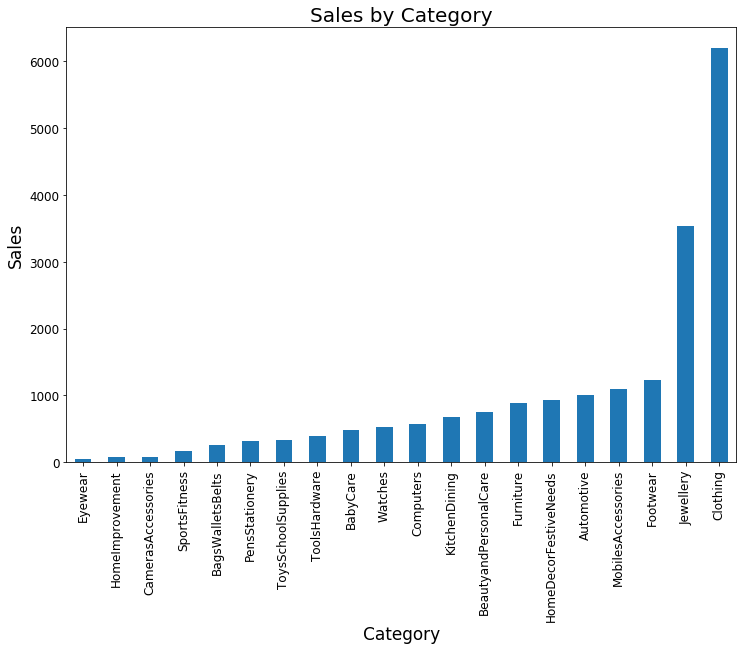

In [10]:
# To visualize the number of items sold in each category

plt.figure(figsize=(12,8))
data.product_category_tree.value_counts()[:20].sort_values(ascending=True).plot(kind='bar')
plt.title("Sales by Category",fontsize=20)
plt.xlabel("Category", fontsize = 17)
plt.ylabel("Sales", fontsize=17)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()


#### Considering only the relevant data
Only those rows are being considered that belong to the top 20 categories.
This is because the rest of the categories are very low in number. The model will not
learn anything from the description of those categories, and it might lead to overtraining.
Description will be used as the main feature for the model. The following code creates a new dataframe with only the relevant data. 

'categories_to_consider' is a list that stores the entries from the 'product_category_tree' that belong to the top 20 categories and hence, will be considered. 'df' is the new dataframe with only the relevant data.

In [11]:

categories_to_consider = list(data.groupby('product_category_tree').count().sort_values(by='uniq_id',ascending=False).head(20).index)

df = data[data.product_category_tree.isin(categories_to_consider)]
df = df[['product_category_tree', 'description']]

encoder is an object of LabelEncoder class. When the fit_transform method of the encoder object is invoked with the target variable as argument, it returns the encoded values; which is then assigned to the original column in the DataFrame.

In [12]:
# Encoding the data
# The LabelEncoder assigns a unique numerical value to each category. 

encoder = LabelEncoder()

encoded_categories = encoder.fit_transform(df['product_category_tree'])

df['product_category_tree'] = encoded_categories

In [13]:
df.shape

# Now, we have 19569 rows and 2 columns and we will be training our model on this data

(19569, 2)

## Training the model

In [14]:
# Splitting the data into train and test sets with test set 20% of the entire dataset

train_x, test_x, train_y, test_y = train_test_split(df.description.fillna(''), df.product_category_tree, test_size = 0.2)

CountVectorizer is used to transform a given text into a vector on the basis of the frequency of each word in the text. CountVectorizer returns a matrix in which the columns contain each unique word in the document. The rows contain the text samples. The values in the cells give the frequency of occurence of the word in that text sample. The paramter stop_words of the CountVectorizer class is set to "english". This is done so that the model ignores irrelevant and commonly used words in English language that do not contribute to the data processing. 

In [16]:
# Converting the training data to a vectorized form using CountVectorizer

vectorizer = CountVectorizer(stop_words = "english")

X_train_matrix = vectorizer.fit_transform(train_x)

# vocabulary_ attribute of the CountVectorizer object returns a dictionary of the identified unique words and their indices
# print("Vocabulary: ", vectorizer.vocabulary_)

In [17]:
# Fitting and scoring the training data using the Multinomial naive bayes model
# The Multinomial Naive bayes classifier is suitable for text classification with discrete features. 

model = MultinomialNB()

model.fit(X_train_matrix, train_y)

print(model.score(X_train_matrix, train_y))

0.9501117853720856


In [18]:
# scoring the test data

X_test_matrix = vectorizer.transform(test_x)


print(model.score(X_test_matrix, test_y))

predicted_result = model.predict(X_test_matrix)
print(classification_report(test_y, predicted_result))


0.9315278487480838
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       212
           1       0.92      0.65      0.76        92
           2       0.79      0.61      0.69        49
           3       0.86      0.94      0.90       131
           4       1.00      0.33      0.50        18
           5       0.98      0.99      0.99      1245
           6       0.93      0.80      0.86       108
           7       1.00      1.00      1.00        10
           8       0.97      0.92      0.94       255
           9       0.89      0.97      0.93       176
          10       0.90      0.98      0.94       193
          11       1.00      0.26      0.42        19
          12       0.86      1.00      0.92       714
          13       0.96      0.92      0.94       128
          14       0.98      0.93      0.95       199
          15       0.95      0.47      0.63        76
          16       1.00      0.40      0.57        40
        

The following code block tests how the model performs on an input which is slightly different from that in the dataset

In [23]:
print(encoder.inverse_transform(model.predict(vectorizer.transform(["Women's ethnic sandals. Material: Leather."]))))
print(encoder.inverse_transform(model.predict(vectorizer.transform(["Full-sleeve embroidered women's top"]))))
print(encoder.inverse_transform(model.predict(vectorizer.transform(["Fabric double sofa bed"]))))
print(encoder.inverse_transform(model.predict(vectorizer.transform(["diamond earring gold plated"]))))
print(encoder.inverse_transform(model.predict(vectorizer.transform(["Pizza slicer"]))))
print(encoder.inverse_transform(model.predict(vectorizer.transform(["Peacock With Meena Art Showpiece"]))))
print(encoder.inverse_transform(model.predict(vectorizer.transform(["Cricket bat"]))))

# Testing the model on different types of inputs


['Footwear']
['Clothing']
['Furniture']
['Jewellery']
['KitchenDining']
['HomeDecorFestiveNeeds']
['SportsFitness']


The model has an overall accuracy of 93% on the test data and 95% on the training data. 

Some ideas to improve the accuracy of the model:
1. Using a more exhaustive list of stop-words in the testing data. 
2. Performing lemmatization: The process of normalizing different grammatical variations of a word to its root form. 

In this model, the vectorizer used is CountVectorizer. The same could have been done using TfidfVectorizer as well.

Other algorithms that can be implemented: Support Vector Classifier, Decision Tree Classifer. 


References:
1. https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/
2. https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
3. https://docs.w3cub.com/scikit_learn/modules/generated/sklearn.naive_bayes.multinomialnb.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
